# Segmentation des cellules


Attention, il faut avoir fait tourner le programme précédent pour que celui-ci fonctionne.

## Settings

### Montez gdrive


In [1]:
from google.colab import drive
drive.mount('/gdrive')

In [10]:
%cd /gdrive/My\ Drive/deep_data

In [11]:
%ls

In [12]:
%ls data_madeToday/

### imports

In [13]:
%reset -f

In [14]:
import os
import shutil

import time
import numpy as np
import matplotlib.pyplot as plt

import time
from IPython.display import Image
import json

import scipy
from sklearn.feature_extraction import image

import torch


### Dossiers et paramètres globaux

In [15]:
"the directory where the data was prepared"
DIR_FOR_DATA="data_madeToday"

"""taille des images"""
PATCH_SIZE = 64
BATCH_SIZE = 32

#un dico pour sauver les hyperparamètre de notre entrainement
memo_train={}
memo_train["PATCH_SIZE"]=PATCH_SIZE
memo_train["BATCH_SIZE"]=BATCH_SIZE
torch.save(memo_train, "memo_train")

## Data

### Charger les données augmentées

Il s'agit des tensers crées dans le notebook précédent.

In [16]:
"to restart without generating the ground truth"
def loadOneKindOfData(trainOrTest):
    path_X= f"{DIR_FOR_DATA}/X_{trainOrTest}.npy"
    path_Y= f"{DIR_FOR_DATA}/Y_{trainOrTest}_unit8.npy"

    X=np.load(path_X)
    Y=np.load(path_Y)

    return X,Y

In [17]:
%%time
X_test_np,Y_test_np=loadOneKindOfData("test")

In [18]:
np.unique(Y_test_np)

In [19]:
%%time
X_train_np,Y_train_np=loadOneKindOfData("train")

In [20]:
print(X_train_np.shape,Y_train_np.shape)

### On passe en torch et sur le GPU

In [21]:
torch.set_default_device("cuda")
#torch.set_default_device("cpu")

In [22]:
def transform(np_tensor):
    tens=torch.tensor(np_tensor)
    return tens.permute(0,3,1,2)

X_test,Y_test=transform(X_test_np),transform(Y_test_np)
X_train,Y_train=transform(X_train_np),transform(Y_train_np)

In [23]:
print(X_train.shape,Y_train.shape,X_train.device)

### Création des vignettes (=imagette=patches)


Puisqu'on dispose de très peu d'images, on va les découper en petites vignettes que l'on montrera au modèle. Il y a un multitudes de vignettes possibles pour chanque images,  qui sont aussi multipliée par l'augmentation par rotation, cela fait beaucoup de données au final.

In [24]:
for _ in range(10):
    Y=Y_test[0]
    patch_size=10

    w,h=Y.shape[1],Y.shape[2]
    i=np.random.randint(0,h-patch_size)
    j=np.random.randint(0,w-patch_size)
    y=Y[:,i:i+patch_size,j:j+patch_size]
    print(y[0,:,:])

In [25]:
def getPatchesForOneEpoch(Xs,Ys,patch_size,n_patch_per_img,convert_Y_to_float):


    res_X=[]
    res_Y=[]

    """on les prend nbVignette vignette dans chaque image"""
    for X,Y in zip(Xs,Ys):
        w,h=X.shape[1],X.shape[2]
        n=0
        while n<n_patch_per_img:
            i=np.random.randint(0,h-patch_size)
            j=np.random.randint(0,w-patch_size)
            y=Y[:,i:i+patch_size,j:j+patch_size]

            if torch.sum(y==0)==0:
                x=X[:,i:i+patch_size,j:j+patch_size]
                res_X.append(x)
                res_Y.append(y-1)
                n+=1


    res_X=torch.stack(res_X)
    res_Y=torch.stack(res_Y)
    perm=np.random.permutation(len(res_X))
    res_X=res_X[perm]
    res_Y=res_Y[perm]

    if convert_Y_to_float:
        res_Y=res_Y.to(torch.float32)


    return res_X,res_Y

def test():
    Xs=torch.rand(2,3,100,100)
    Ys=torch.rand(2,1,100,100)
    res_X,res_Y=getPatchesForOneEpoch(Xs,Ys,10,15,True)
    print(res_X.shape,res_Y.shape)
test()

***A vous:*** Expliquez $(2\heartsuit)$ comment on c'est débarrasser du padding (de valeur 0) que l'on avait introduit lors des rotations.

In [26]:
X_patch,Y_patch=getPatchesForOneEpoch(X_test,Y_test,PATCH_SIZE,5,True)
print(X_patch.shape,Y_patch.shape)

In [27]:
torch.unique(Y_patch)

***A vous:*** Que signifie maintenant les catégories 0 et 1 $(1\heartsuit)$?

In [28]:
nb=20
fig,axs=plt.subplots(nb,2,figsize=(7,nb*3))
print(axs.shape)

for i in range(nb):
    x,y=X_patch[i],Y_patch[i]
    axs[i,0].imshow(x.permute(1,2,0).cpu())
    axs[i,1].imshow(y.permute(1,2,0).cpu())
    axs[i,0].axis("off")
    axs[i,1].axis("off")

## Le modèle

Pour repérer  les cellules, nous allons utiliser un Vnet qui est un modèle récent et très efficace. Le Vnet est une légère amélioration du Unet dont on analysera le dessin en premier.

Il est surtout important de noter que ces réseaux produisent en sorties des images de la même taille que l'image d'entrée:

* En entrée on mettra les images des cellules
* En sortie, on espère recréer les masques qui permettent de repérer (=segmenter) les cellules.

### Le dessin d'un Unet


Le U-net fait parti des réseau "full-convolutional". Il a été introduit par Olaf Ronneberger, Philipp Fischer, Thomas Brox dans cet [article](https://arxiv.org/abs/1505.04597).


Voici un dessin correspondant à un Unet. Le dessin du Vnet sera quasi-identique. On s'amusera plus loin à regarder les petites différences.  

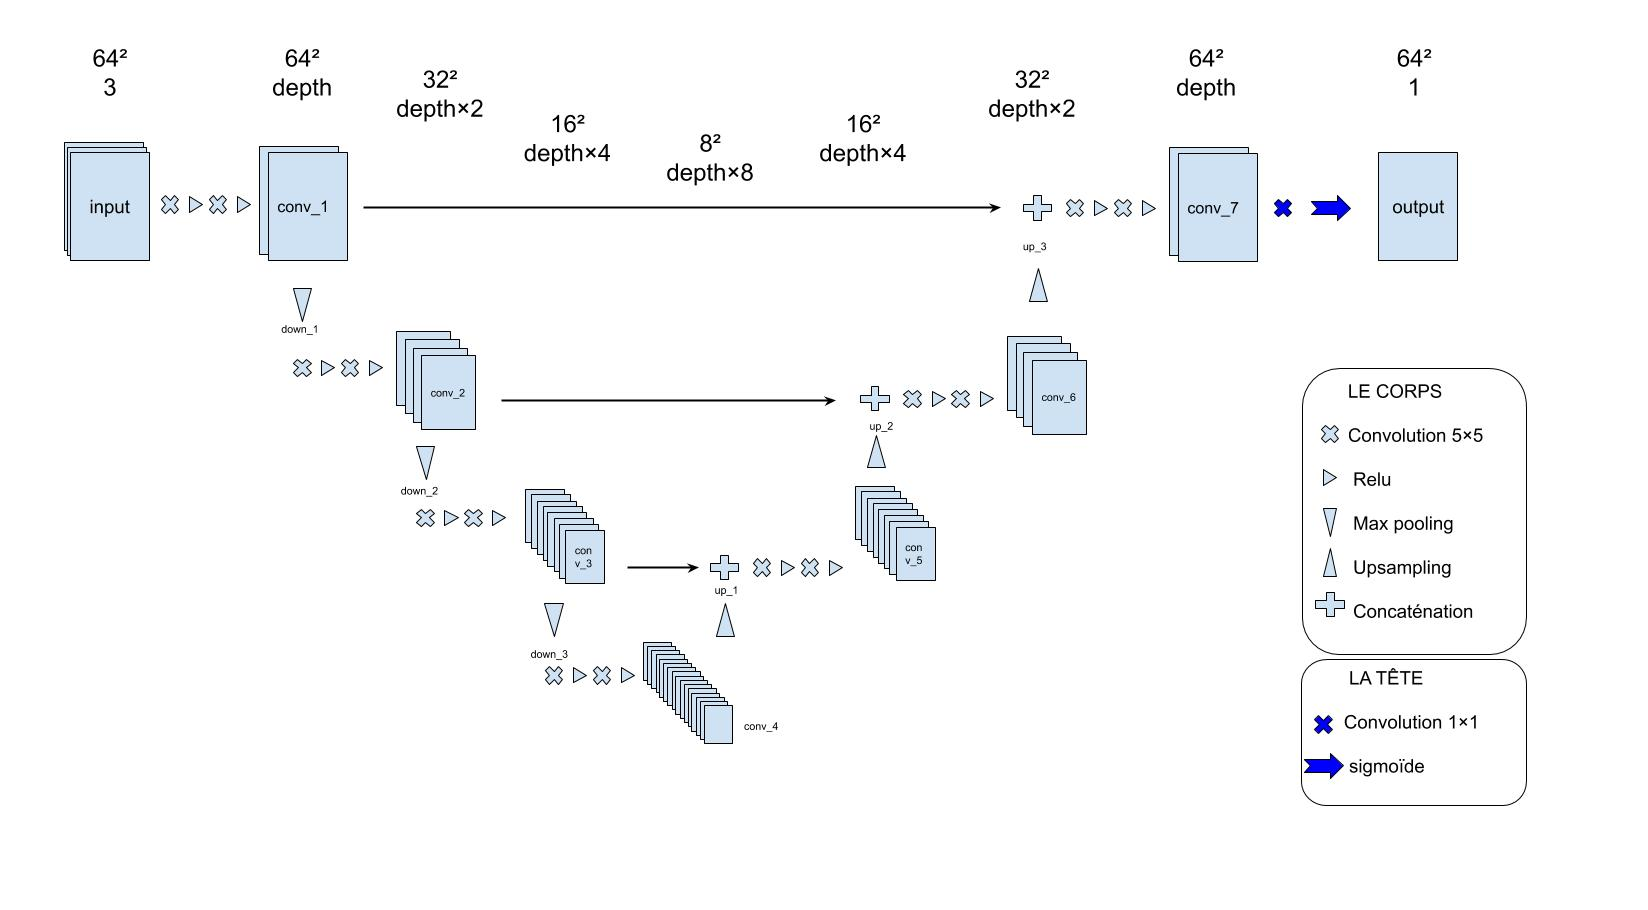

Interprétons le dessin ci-dessus.

Le paramètres `depth` correspond à la profondeur du premier layer (juste après l'entrée).

Coupons  le dessin en deux verticalement  (en enlevant pour l'instant les 3 grand traits horizontaux).

* ***La partie gauche = l' analyse.*** C'est exactement un CNN  comme nous l'avons déjà vu  MAIS sans la partie fully-connected.  Chaque layer diminue la taille des images d'un facteur 2 à l'aide d'un max pooling, et multiplie la `depth` par 2. A la fin  (=tout en bas) on obtient `depth`*8 images de taille $8*8$. Ce sont des feature (=motifs) qui synthétisent les informations importantes de l'image. On peut faire un parallèle avec la décomposition en ondelette (ex: JPEG): chaque feature correspond à des coordonnées relatives à une ondelette.


* ***La partie droite = la synthèse.*** C'est  un miroir de la partie gauche. Elle sert à combiner les feature pour reconstituer l'output (= la vérité terrain=le masque).  La  résolution des images est doublée à chaque layer, et simultanément, on diminue la profondeur. Pour dilater les images, on utilise  des `up-sampling`: on répette simplement chaque pixels 4 fois.


* ***Les grand racoursis:*** Se sont les longues flèches horizontales. Elles aident à augmenter la résolution en rajoutant des détails immédiatement issus de la partie gauche.

* ***La toute fin:*** On termine par une sigmoïde, ce qui nous indique que le présent dessin est relatif à un réseau effectuant de la ...  $(1\heartsuit)$.

### Le code d'un Unet



***A vous:*** $(4\heartsuit)$ Ajoutez des commentaires au programme suivant (version initiale ou votre version modifiée) pour préciser la shape des tenseurs qui apparaissent succéssivement: `conv_1`, `down_1`, `up_1`, etc.  Ce n'est pas difficile: la dimension du signal diminue en même temps qu'augmente le nombre de channel, et inversement.

In [29]:
upsample=torch.nn.UpsamplingNearest2d(scale_factor=2)
X=torch.tensor([[1.,2],[3,4]])
X=X[None,None,:,:]
upsample(X)

In [30]:
len(list(upsample.parameters()))

In [31]:
class TwoConv(torch.nn.Module):
    def __init__(self,dim_in,dim_out):
        super().__init__()
        self.layer1=torch.nn.Conv2d(dim_in,dim_out,(3,3),padding="same",padding_mode="reflect")
        self.layer2=torch.nn.Conv2d(dim_out,dim_out,(3,3),padding="same",padding_mode="reflect")

    def forward(self,X):
        X=torch.relu(self.layer1(X))
        return torch.relu(self.layer2(X))

def test():
    block=TwoConv(3,6)
    Y=block(torch.rand(1,3,12,12))
    print(Y.min(),Y.max())
    assert Y.shape==(1,6,12,12)
test()

In [32]:
class Unet(torch.nn.Module):
    def __init__(self,dim_in, depth,dim_out,final_actfn):
        super().__init__()
        self.dim_in=dim_in
        self.final_actfn=final_actfn

        self.block_1=TwoConv(dim_in, depth)
        self.block_2=TwoConv(depth, depth*2)
        self.block_3=TwoConv(depth*2, depth*4)
        self.block_4=TwoConv(depth*4, depth*8)
        #remontée
        self.block_5=TwoConv(depth*12,depth*4)
        self.block_6=TwoConv(depth*6,depth*2)
        self.block_7=TwoConv(depth*3,depth)

        self.output_layer=torch.nn.Conv2d(depth,dim_out,(1,1))


    def forward(self,X):
        assert X.shape[1]==self.dim_in

        #deux fonctions:
        max_pool=torch.nn.MaxPool2d(2)
        upsampling=torch.nn.UpsamplingNearest2d(scale_factor=2)


        #descente
        conv_1=self.block_1(X)                  #(b,d,h,w)
        down_1=max_pool(conv_1)                 #(b,d,h/2,w/2)

        conv_2=self.block_2(down_1)             #(b,d*2,h/2,w/2)
        down_2=max_pool(conv_2)                 #(b,d*2,h/4,w/4)


        conv_3=self.block_3(down_2)             #(b,d*4,h/4,w/4)
        down_3=max_pool(conv_3)                 #(b,d*4,h/8,w/8)


        conv_4=self.block_4(down_3)             #(b,d*8,h/8,w/8)

        #remontée
        up_1 =  upsampling(conv_4)              #(b,d*8,h/4,w/4)
        Y = torch.cat([conv_3, up_1], dim=1)    #(b,d*12,h/4,w/4)
        conv_5 = self.block_5(Y)                #(b,d*4,h/4,w/4)

        up_2 =  upsampling(conv_5)              #(b,d*4,h/2,w/2)
        Y = torch.cat([conv_2, up_2], dim=1)    #(b,d*6,h/2,w/2)
        conv_6 = self.block_6(Y)                #(b,d*2,h/2,w/2)

        up_3 =  upsampling(conv_6)              #(b,d*2,h,w)
        Y = torch.cat([conv_1, up_3], dim=1)    #(b,d*3,h,w)
        conv_7 = self.block_7(Y)                #(b,d,h,w)

        return self.final_actfn(self.output_layer(conv_7))        #(b,dim_out,h,w)


In [33]:
ni,nj=5,5 #batch_size,dim_out


w,h=64,64

depth=32
#dim_in=1
model=Unet(1,depth,nj,torch.sigmoid)

hh=torch.linspace(0,10,h)
ww=torch.linspace(0,10,w)
H,W=torch.meshgrid(hh,ww,indexing="xy")

X=torch.zeros([ni,1,w,h])

for i in range(ni):
    X[i,0,:,:]=torch.sin(i*H)*torch.sin(i*W)

Y=model(X)
assert Y.shape==(ni,nj,w,h),f"{Y.shape}!={(ni,nj,w,h)}"

In [34]:
def plot_img(Y,same_range):
    if same_range:
        vmin=torch.min(Y)
        vmax=torch.max(Y)
    else:
        vmin,vmax=None,None
    ni,nj=Y.shape[0],Y.shape[1]
    fig,ax=plt.subplots(ni,nj,figsize=(2*nj,2*ni),sharex="all",sharey="all")
    ax=np.reshape(ax,[ni,nj])
    for i in range(ni):
        for j in range(nj):
            y=Y[i,j,:,:]
            ax[i,j].imshow(y.detach().cpu(),vmin=vmin,vmax=vmax)

In [35]:
plot_img(X,False)

In [36]:
plot_img(Y,False)

In [37]:
plot_img(Y,True)

#### ♡

Qu'est-ce qu'on doit changer dans le modèle pour obtenir ce resultat là?

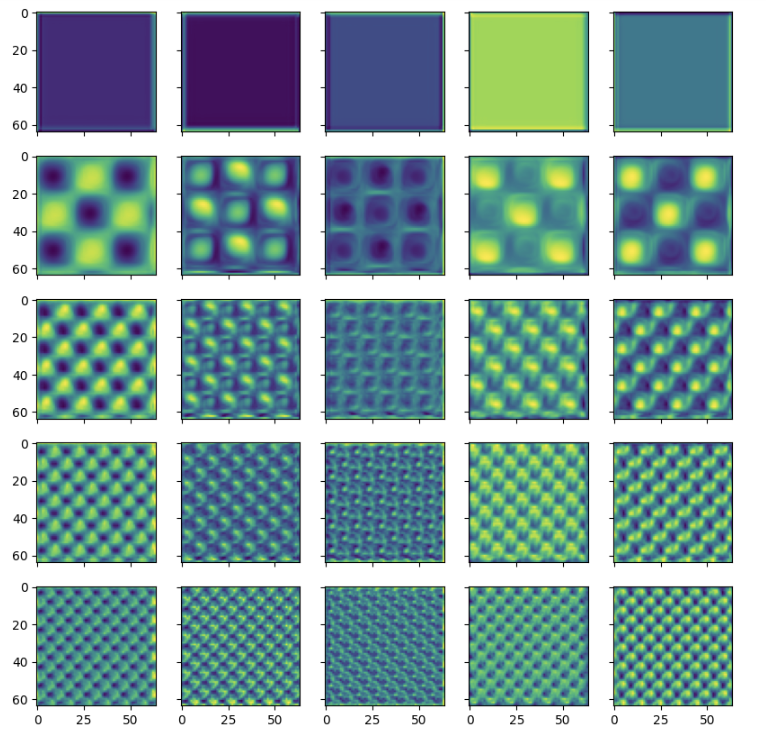

***A vous:*** Comparez notre U-net avec le U-net de l'article orginel $(5\heartsuit)$.

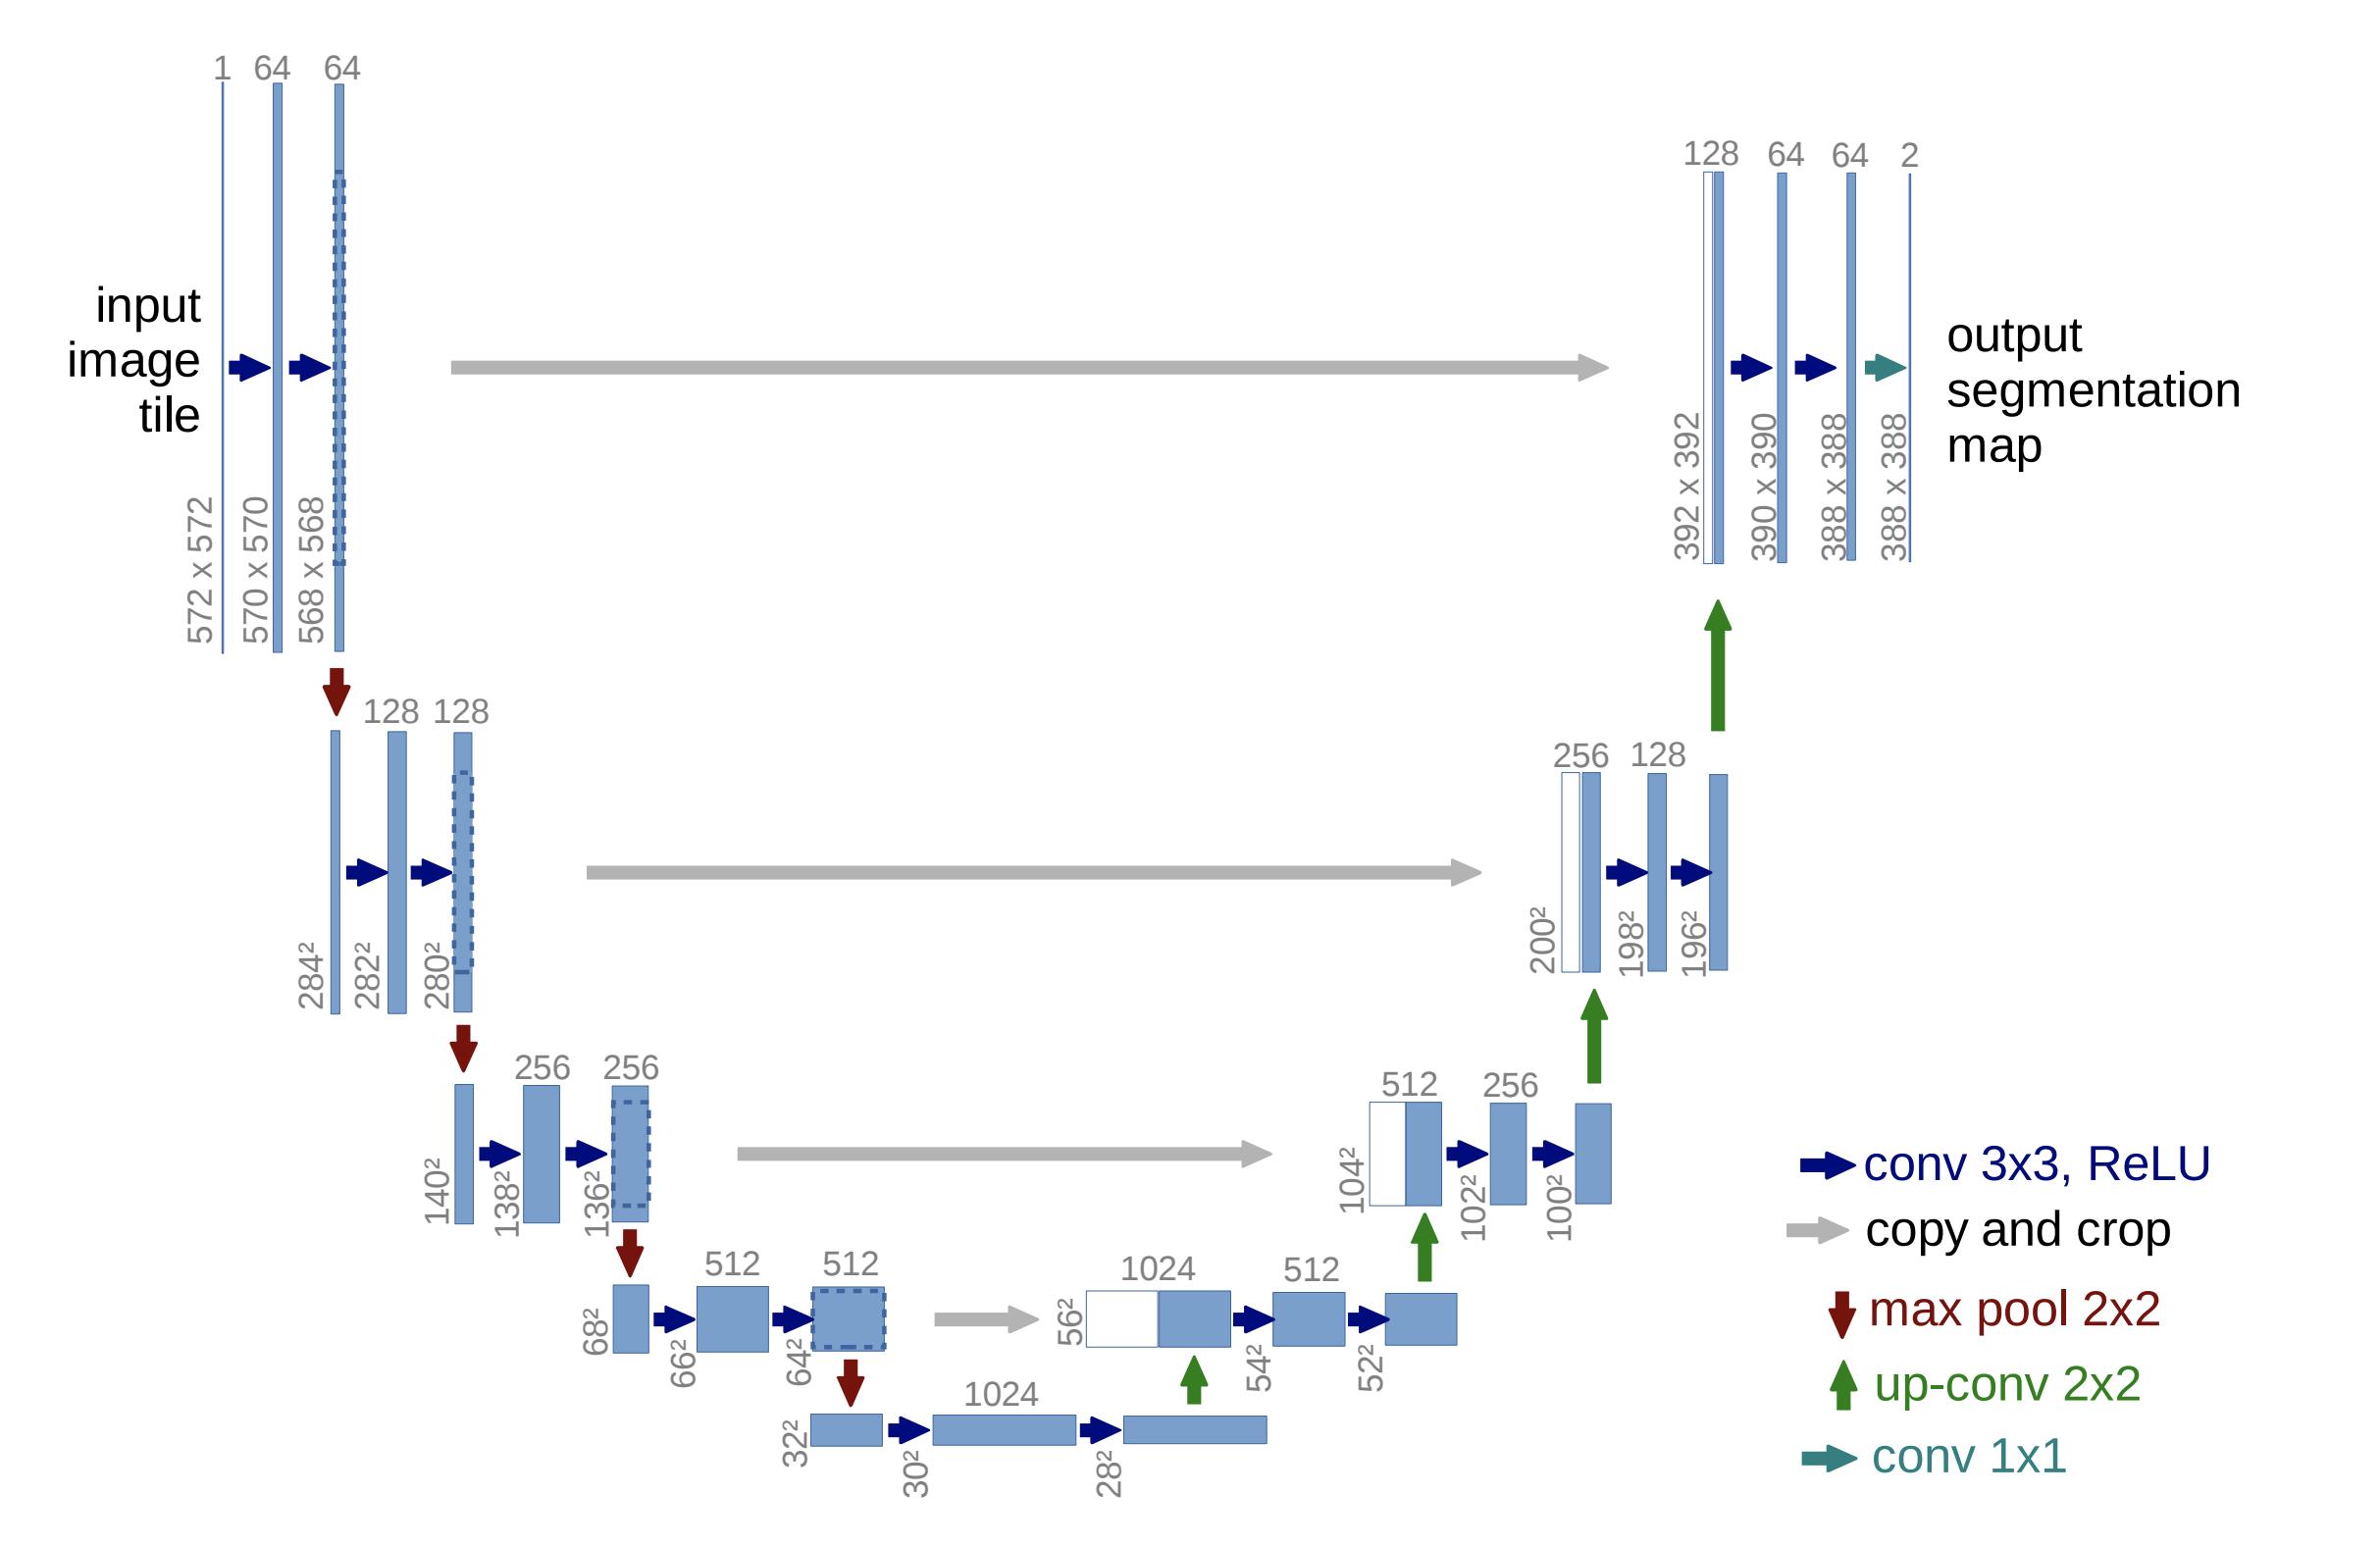

### Le dessin d'un Vnet

Le Vnet est le petit frère du Unet. Il est un tout petit peu plus complexe (c'est pour cela que l'on commence par comprendre le Unet).





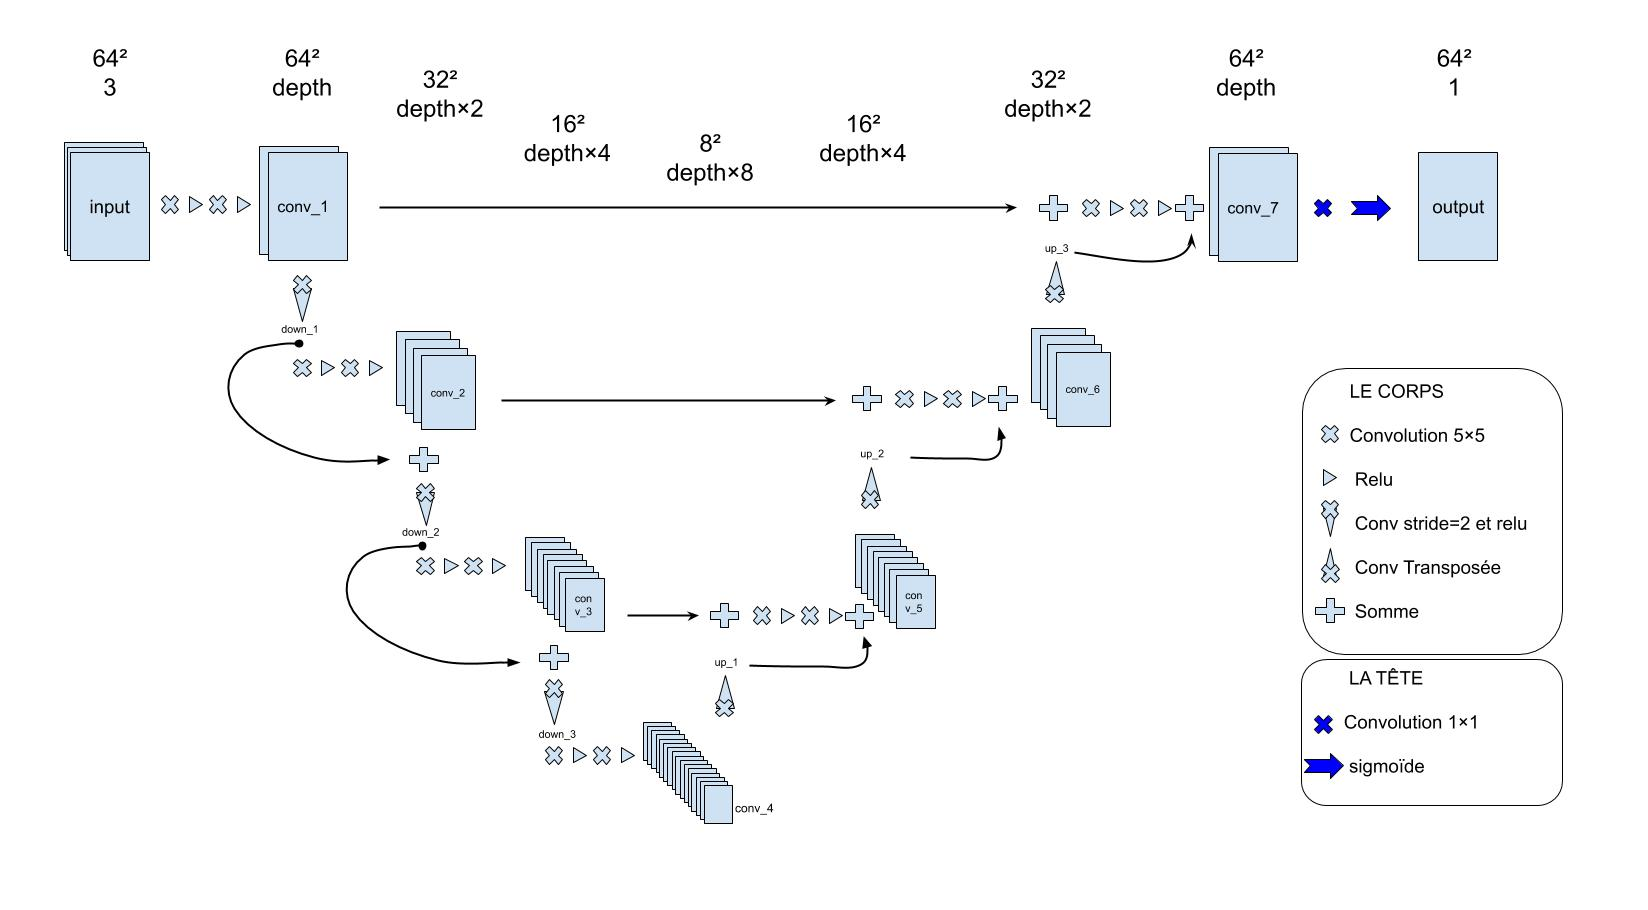

Listes de différences:

* Les max-polling sont remplacés par convolution avec `stride=2`. Cela produit une compression plus douce.

* On utilise des racoursis verticaux à la "resNet".

* les `upSampling` sont immédiatements lissés (observez les noyaux de convolution de lissage)

* On a ajouté une batch normalisation et un spacial-droptout (qui ne sont pas noté dans le dessin).

* On a remplacer les concaténations par des sommations, ce qui diminue le nombre de paramètre.


***A vous:*** Indiquez avec des commentaires dans le code, à quels endroit ont lieu les racoursis verticaux et horizontaux.


Inclure les images ci-dessous pour la convolution transposée

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

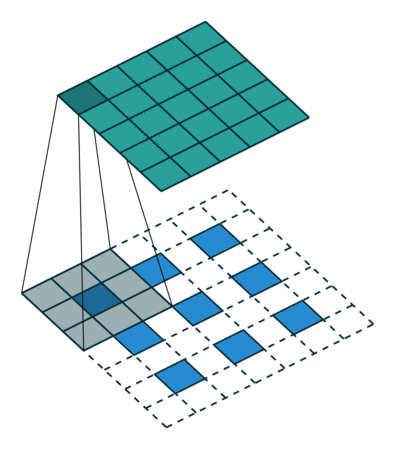

In [38]:
dim_in,dim_out=2,3
m = torch.nn.ConvTranspose2d(dim_in, dim_out, (3,3), stride=2)
Y=m(torch.ones([1,dim_in,10,10]))
Y.shape

In [39]:
plt.matshow(Y[0,0,:,:].detach().cpu())
plt.colorbar();

## Train et validation

### La loss

In [40]:
zero=torch.zeros([2,2,4,5])+1e-7
one=torch.ones([2,2,4,5])-1e-7

In [41]:
loss=torch.nn.functional.binary_cross_entropy(one,one)
loss

In [42]:
loss=torch.nn.functional.binary_cross_entropy(zero,zero)
loss

In [43]:
loss=torch.nn.functional.binary_cross_entropy(zero,one)
loss

### Un agent

In [44]:
class Agent:

    def __init__(self):

        self.convert_Y_to_float=True

        self.path_to_save="model"

        # self.loss_fn=lambda a,b:torch.mean((a-b)**2) #TODO dice_loss_2D
        self.loss_fn=torch.nn.functional.binary_cross_entropy #attention à l'ordre des arguments: y_pred=input , y_true=tardge
        #self.loss_fn=dice_coef_2D
        self.model = Unet(3,32,1,torch.sigmoid)

        self.batch_size=BATCH_SIZE

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.losses=[]
        self.val_steps=[]
        self.val_losses=[]
        self.step_count=-1

        #le jeu de validation est prix dans le jeu train, le tirage aléatoire des patchs fait qu'il n'est pas exactement égal à un jeu train.
        #Dans l'idéal, il aurait fallu séparer le jeu d'image en 3 dès le début.
        self.x_val,self.y_val=getPatchesForOneEpoch(X_train,Y_train,PATCH_SIZE,5,self.convert_Y_to_float)

    def plot_loss(self):
        fig,ax=plt.subplots()
        ax.plot(self.losses)
        ax.plot(self.val_steps,self.val_losses)



    def train_step(self,x,y):
        pred = self.model(x)
        loss = self.loss_fn(pred,y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss


    def val_step(self,x,y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fn(pred,y)
        return loss


    def train(self,nb_epochs):
        n_patch_per_img=5
        batch_size=32

        for _ in range(nb_epochs):

            X_patch,Y_patch=getPatchesForOneEpoch(X_train,Y_train,PATCH_SIZE,n_patch_per_img,self.convert_Y_to_float)
            n_batch=len(X_patch)//batch_size
            for i in range(n_batch):
                sl=slice(i*batch_size,(i+1)*batch_size)
                x,y=X_patch[sl],Y_patch[sl]
                self.step_count+=1
                loss=self.train_step(x,y)
                self.losses.append(loss.detach().cpu().item())

            val_loss=self.val_step(self.x_val,self.y_val).cpu().item()
            self.val_losses.append(val_loss)

            if val_loss<=np.min(self.val_losses):
                print(f"⬊{val_loss:.4g}",end="")
                torch.save(self.model,self.path_to_save)

            else:
                print("⬈",end="")

            self.val_steps.append(self.step_count)

    def set_model_at_best(self):
        self.model=torch.load(self.path_to_save)

### Entrainement

In [45]:
agent=Agent()

In [46]:
agent.train(20)

In [47]:
agent.train(20)

In [48]:
agent.plot_loss()

## Test

In [49]:
agent.set_model_at_best()

In [50]:
X_test_patch,Y_test_patch=getPatchesForOneEpoch(X_test,Y_test,PATCH_SIZE,2,True)

In [51]:
X_test_patch.shape,Y_test_patch.shape

In [52]:
Y_pred_patch=agent.model(X_test_patch)
Y_pred_patch.shape


In [53]:
nb=10
fig,axs=plt.subplots(nb,4,figsize=(6,nb*2),sharex="all",sharey="all")
print(axs.shape)

for i in range(nb):
    x,y,y_pred=X_test_patch[i,:,:,:],Y_test_patch[i,0,:,:],Y_pred_patch[i,0,:,:]
    axs[i,0].imshow(x.permute(1,2,0).detach().cpu())
    axs[i,1].imshow(y.detach().cpu())
    axs[i,2].imshow(y_pred.detach().cpu())
    axs[i,3].imshow(y_pred.detach().cpu()>0.5)

## Une Loss adaptée à la segmentation de petits objets

### dice 1D

Considérons deux matrices `y_true` et  `y_pred`. Imaginons dans un premier temps qu'elles sont constituées de 0 et de 1. On peut donc les assimiler à des ensembles:

* `y[i,j]=1` <=> `(i,j)` est dans l'ensemble.
* `y[i,j]=0` <=> `(i,j)` n'est pas dans l'ensemble.

    
La `dice(y_true,y_pred)` est donnée par:

        intersection = sum(y_true * y_pred)
        dice = (2. * intersection ) / (sum(y_true) + sum(y_pred) )



*  Que vaut la dice quand ces 2 ensembles sont égaux?
*  Et quand ils sont disjoints?
*  La dice est une variante de la fonction loss "intersection_over_union" (IoU). Pour obtenir cette dernière il faut modifier légèrement le dénominateur de la dice. Devinez comment.


Maintenant, quand `y_true` et  `y_pred` prennent des valeurs dans l'intervalle $[0,1]$, il faut les considérer comme des ensemble "flous" ou probabiliste: `y[i,j]=0.5` signifie que le pixel `(i,j)` est dans l'ensemble avec proba $\frac 12$ . L'interprétation du coefficient dice reste la même.


In [54]:
y_true=torch.zeros([10,10])
y_true[:6]=1

y_pred=torch.zeros([10,10])
y_pred[5:]=1

In [55]:
fig,(ax0,ax1)=plt.subplots(1,2)
ax0.imshow(y_true.cpu())
ax0.set_title("y_true")
ax1.imshow(y_pred.cpu())
ax1.set_title("y_pred");

In [56]:
y_true=y_true[None,None,:,:]
y_pred=y_pred[None,None,:,:]

In [57]:
def dice_coef_2D(y_true, y_pred,smooth=1e-5):
    intersection = torch.sum(y_true * y_pred,dim=[2,3])
    dice_per_batch_and_channel= (2. * intersection + smooth) / (torch.sum(y_true,dim=[2,3]) + torch.sum(y_pred,dim=[2,3]) + smooth)
    return torch.mean(dice_per_batch_and_channel)

In [58]:
"testons"
dice_coef_2D(y_true,y_pred,smooth=0).cpu()

In [59]:
dice_coef_2D(y_true,y_true,smooth=0).cpu()

Bien entendu, nous voulons maximiser la dice, il faut donc introduire un signe moins.

In [60]:
def dice_loss_2D(y_true, y_pred):
    smooth=1e-5
    return 1-dice_coef_2D(y_true, y_pred,smooth)

***A vous:*** Quel est la plage de valeur possible pour la `dice_loss` $(1\heartsuit)$?

### Variante: Tversky loss

[lien](https://arxiv.org/pdf/1706.05721.pdf)

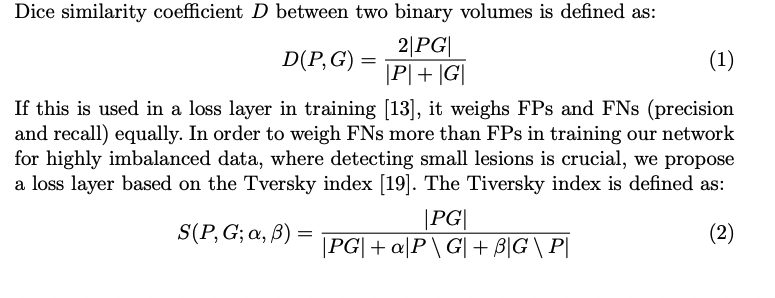